In [647]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from datetime import datetime
import time
import math

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [648]:
train = pd.read_csv('train_begin.csv')
test = pd.read_csv('test_begin.csv')
submission = pd.read_csv('./sample_submission.csv')

In [649]:
all_data = pd.concat([train, test], sort=False)

# 범주형 수치형으로 변경

In [650]:
# 인코딩할 열 이름의 접미사 리스트
suffixes = ['Dam', 'Fill1', 'Fill2']

# LabelEncoder 객체 생성
le = LabelEncoder()

# 각 접미사에 대해 LabelEncoder를 적용
for suffix in suffixes:
    for column in [f'Equipment_{suffix}']:
        all_data[column] = all_data[column].astype(str)
        le.fit(all_data[column])
        all_data[column] = le.transform(all_data[column])


In [651]:
l1=['Model.Suffix_AutoClave','Model.Suffix_Fill1','Model.Suffix_Fill2',
    'Workorder_AutoClave','Workorder_Fill1','Workorder_Fill2',
    'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2',]
all_data = all_data.drop(l1, axis=1)

In [652]:
l1=['Model.Suffix_Dam','Workorder_Dam']
for column in l1:
    all_data[column] = all_data[column].astype(str)
    le.fit(all_data[column])
    all_data[column] = le.transform(all_data[column])

In [653]:
all_data['Chamber Temp. Judge Value_AutoClave'] = all_data['Chamber Temp. Judge Value_AutoClave'].astype(str)
le.fit(all_data['Chamber Temp. Judge Value_AutoClave'])
all_data['Chamber Temp. Judge Value_AutoClave'] = le.transform(all_data['Chamber Temp. Judge Value_AutoClave'])

In [654]:
# LabelEncoder 객체 생성
le = LabelEncoder()
all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].astype(str)
le.fit(all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'])
all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = le.transform(all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'])
all_data = all_data.drop(columns='GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave')

In [655]:
# 'object' 타입 열 선택
object_columns = all_data.select_dtypes(include=['object']).columns

print(f"Object type columns: {object_columns}")

Object type columns: Index(['Wip Line_Dam', 'Process Desc._Dam', 'Insp Judge Code_Dam',
       'Wip Line_AutoClave', 'Process Desc._AutoClave', 'Equipment_AutoClave',
       'Insp Judge Code_AutoClave', '1st Pressure Judge Value_AutoClave',
       '2nd Pressure Judge Value_AutoClave',
       '3rd Pressure Judge Value_AutoClave', 'Wip Line_Fill1',
       'Process Desc._Fill1', 'Insp Judge Code_Fill1', 'Wip Line_Fill2',
       'Process Desc._Fill2', 'Insp Judge Code_Fill2', 'target', 'Set ID'],
      dtype='object')


In [656]:
all_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,WorkMode Collect Result_Fill2,target,Set ID
0,IVI-OB6,Dam Dispenser,0,3,658,1,OK,240.0,2.5,-90,...,91.8,270.0,50,114.612,19.9,7.0,127,NaN,Normal,NaN
1,IVI-OB6,Dam Dispenser,0,3,284,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85.000,19.6,7.0,185,0.0,Normal,NaN
2,IVI-OB6,Dam Dispenser,1,0,590,1,OK,1000.0,12.5,90,...,91.8,270.0,50,114.612,19.8,10.0,73,NaN,Normal,NaN
3,IVI-OB6,Dam Dispenser,1,0,252,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85.000,19.9,12.0,268,0.0,Normal,NaN
4,IVI-OB6,Dam Dispenser,0,0,143,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85.000,19.7,8.0,121,0.0,Normal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,IVI-OB6,Dam Dispenser,1,0,278,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85.000,19.5,14.0,131,NaN,NaN,ffea508b59934d689b540f95eb3fa730
17357,IVI-OB6,Dam Dispenser,1,0,440,1,OK,1000.0,12.5,90,...,91.8,270.0,50,85.000,19.8,12.0,279,NaN,NaN,ffed8923c8a448a98afc641b770be153
17358,IVI-OB6,Dam Dispenser,0,0,315,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85.000,20.5,4.0,66,NaN,NaN,fff1e73734da40adbe805359b3efb462
17359,IVI-OB6,Dam Dispenser,0,0,8,1,OK,240.0,2.5,-90,...,91.8,270.0,50,85.000,18.9,1.0,117,0.0,NaN,fff8e38bdd09470baf95f71e92075dec


# 전처리

In [657]:
# # Equipment_Dam, Equipment_Fill1, Equipment_Fill2의 값을 비교하여 다르면 1, 같으면 0으로 표시
# all_data['Is_Equipment_Consistent'] = np.where(
#     (all_data['Equipment_Dam'] == all_data['Equipment_Fill1']) & 
#     (all_data['Equipment_Dam'] == all_data['Equipment_Fill2']), 
#     1,  # 모든 값이 같으면 1
#     0   # 하나라도 다르면 0
# )

# all_data['PalletID'] = np.where(
#     (all_data['PalletID Collect Result_Dam'] == all_data['PalletID Collect Result_Fill1']) & 
#     (all_data['PalletID Collect Result_Dam'] == all_data['PalletID Collect Result_Fill2']), 
#     1,  # 모든 값이 같으면 1
#     0   # 하나라도 다르면 0
# )

all_data['Production Qty'] = np.where(
    (all_data['Production Qty Collect Result_Dam'] == all_data['Production Qty Collect Result_Fill1']) & 
    (all_data['Production Qty Collect Result_Dam'] == all_data['Production Qty Collect Result_Fill2']), 
    1,  # 모든 값이 같으면 1
    0   # 하나라도 다르면 0
)

# # 각 칼럼에서 값이 0 (불일치)이 하나라도 있는 경우 새로운 칼럼에 1로 표시
# all_data['Is_Inconsistent'] = np.where(
#     (all_data['Is_Equipment_Consistent'] == 0) | 
#     (all_data['PalletID'] == 0) | 
#     (all_data['Production Qty'] == 0), 
#     1,  # 하나라도 다르면 1
#     0   # 모두 같으면 0
# )


# all_data = all_data.drop(columns = [
# 'Equipment_Dam','Equipment_Fill1','Equipment_Fill2',
#                                     'PalletID Collect Result_Dam','PalletID Collect Result_Fill1','PalletID Collect Result_Fill2',
#                                     'Production Qty Collect Result_Dam','Production Qty Collect Result_Fill1','Production Qty Collect Result_Fill2'
# ])


In [658]:
# 비대칭성이 큰 피처 목록
# high_skew_cols_list =[
#  'Machine Tact time Collect Result_Fill2',
#  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
#  'CURE END POSITION X Collect Result_Fill2',
#  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
#  'Dispense Volume(Stage2) Collect Result_Fill1',
#  'Receip No Collect Result_Dam',
#  'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#  'Machine Tact time Collect Result_Dam',
#  'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
#  '3rd Pressure Collect Result_AutoClave',
#  '3rd Pressure Unit Time_AutoClave',
#  'Head Zero Position Y Collect Result_Dam',
#  'CURE SPEED Collect Result_Dam',
#  'Head Purge Position Z Collect Result_Fill2',
#  'Machine Tact time Collect Result_Fill1',
#  'Head Purge Position Z Collect Result_Fill1',
#  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
#  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
#  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
#  '1st Pressure 1st Pressure Unit Time_AutoClave',
#  'CURE SPEED Collect Result_Fill2',
#  'THICKNESS 1 Collect Result_Dam',
#  'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#  'THICKNESS 3 Collect Result_Dam',
#  'THICKNESS 2 Collect Result_Dam',
#  'CURE START POSITION Z Collect Result_Fill2',
#  'CURE STANDBY POSITION Z Collect Result_Fill2',
#  'Dispense Volume(Stage1) Collect Result_Fill1',
#  'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
#  'CURE END POSITION Z Collect Result_Fill2',
#  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
#  'CURE START POSITION X Collect Result_Fill2',
#  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
#  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'
# ]

# high_skew_cols_list = [
#     'HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1',
#     'Machine Tact time Collect Result_Fill2',
#     'Dispense Volume(Stage2) Collect Result_Fill1',
#     'Receip No Collect Result_Dam',
#     'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#     'CURE POSITION Z Collect Result_Fill2',
#     'Machine Tact time Collect Result_Dam',
#     'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
#     'Model.Suffix_Dam',
#     '3rd Pressure Collect Result_AutoClave',
#     '3rd Pressure Unit Time_AutoClave',
#     'CURE POSITION X Collect Result_Dam',
#     'Head Zero Position Y Collect Result_Dam',
#     'Head Purge Position Z Collect Result_Fill2',
#     'Machine Tact time Collect Result_Fill1',
#     'Head Purge Position Z Collect Result_Fill1',
#     'HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Dam',
#     '1st Pressure 1st Pressure Unit Time_AutoClave',
#     'THICKNESS 1 Collect Result_Dam',
#     'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#     'THICKNESS 3 Collect Result_Dam',
#     'THICKNESS 2 Collect Result_Dam',
#     'Dispense Volume(Stage1) Collect Result_Fill1',
#     'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
#     'HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Fill1'
# ]


# # 로그 변환을 위한 작은 상수 추가
# epsilon = 1e-6

# # 비대칭성이 큰 피처에 로그 변환 적용
# for col in high_skew_cols_list:
#     if any(all_data[col] <= 0):  # 0 또는 음수 값이 있는 경우 상수 추가
#         all_data[col] = np.log1p(all_data[col] + epsilon)
#     else:
#         all_data[col] = np.log1p(all_data[col])


In [659]:
# 열 목록 정의
cols_to_average = ['Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 평균 값 계산 및 새로운 열 추가
# all_data['Average Stage1 Circle Distance Speed Collect Result_Dam'] = all_data[cols_to_average[:4]].mean(axis=1)
# all_data['Average Stage1 Line Distance Speed Collect Result_Dam'] = all_data[cols_to_average[4:8]].mean(axis=1)
# all_data['Average Stage2 Circle Distance Speed Collect Result_Dam'] = all_data[cols_to_average[8:12]].mean(axis=1)
# all_data['Average Stage2 Line Distance Speed Collect Result_Dam'] = all_data[cols_to_average[12:16]].mean(axis=1)
# all_data['Average Stage3 Circle Distance Speed Collect Result_Dam'] = all_data[cols_to_average[16:20]].mean(axis=1)
# all_data['Average Stage3 Line Distance Speed Collect Result_Dam'] = all_data[cols_to_average[20:24]].mean(axis=1)

# all_data['Average Stage1 CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average[:8]].mean(axis=1)
# all_data['Average Stage2 CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average[8:16]].mean(axis=1)
# all_data['Average Stage3 CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average[16:]].mean(axis=1)

# all_data['Average CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average].mean(axis=1)

# 기존 열 삭제
all_data = all_data.drop(columns=cols_to_average)

In [660]:
cols_to_average = [
                'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',

                  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',

                  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
                     
]

all_data['HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Dam'] = all_data[cols_to_average[:3]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Dam'] = all_data[cols_to_average[3:6]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Dam'] = all_data[cols_to_average[6:9]].mean(axis=1)

all_data['HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1'] = all_data[cols_to_average[9:12]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Fill1'] = all_data[cols_to_average[12:15]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Fill1'] = all_data[cols_to_average[15:18]].mean(axis=1)

# all_data['HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill2'] = all_data[cols_to_average[18:]].mean(axis=1)
# all_data['HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Fill2'] = all_data[cols_to_average[21:24]].mean(axis=1)
# all_data['HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Fill2'] = all_data[cols_to_average[24:]].mean(axis=1)

# 기존 열 삭제
all_data = all_data.drop(columns=cols_to_average)




In [661]:
all_data['CURE POSITION X Collect Result_Dam'] = abs(all_data['CURE START POSITION X Collect Result_Dam']-all_data['CURE END POSITION X Collect Result_Dam'])
all_data['CURE POSITION Z Collect Result_Dam'] = abs(all_data['CURE START POSITION Z Collect Result_Dam']-all_data['CURE END POSITION Z Collect Result_Dam'])
all_data['CURE POSITION Θ Collect Result_Dam'] = abs(all_data['CURE START POSITION Θ Collect Result_Dam']-all_data['CURE END POSITION Θ Collect Result_Dam'])

# all_data['CURE TIME X Collect Result_Dam'] = abs(all_data['CURE START POSITION X Collect Result_Dam']-all_data['CURE END POSITION X Collect Result_Dam'])/all_data['CURE SPEED Collect Result_Dam']
# all_data['CURE TIME Z Collect Result_Dam'] = abs(all_data['CURE START POSITION Z Collect Result_Dam']-all_data['CURE END POSITION Z Collect Result_Dam'])/all_data['CURE SPEED Collect Result_Dam']
# all_data['CURE TIME Θ Collect Result_Dam'] = abs(all_data['CURE START POSITION Θ Collect Result_Dam']-all_data['CURE END POSITION Θ Collect Result_Dam'])/all_data['CURE SPEED Collect Result_Dam']

all_data['CURE POSITION X Collect Result_Fill2'] = abs(all_data['CURE START POSITION X Collect Result_Fill2']-all_data['CURE END POSITION X Collect Result_Fill2'])
all_data['CURE POSITION Z Collect Result_Fill2'] = abs(all_data['CURE START POSITION Z Collect Result_Fill2']-all_data['CURE STANDBY POSITION Z Collect Result_Fill2'])+abs(all_data['CURE STANDBY POSITION Z Collect Result_Fill2']-all_data['CURE END POSITION Z Collect Result_Fill2'])

# all_data['CURE TIME X Collect Result_Fill2'] = abs(all_data['CURE START POSITION X Collect Result_Fill2']-all_data['CURE END POSITION X Collect Result_Fill2'])/all_data['CURE SPEED Collect Result_Fill2']
# all_data['CURE TIME Z Collect Result_Fill2'] = (abs(all_data['CURE START POSITION Z Collect Result_Fill2']-all_data['CURE STANDBY POSITION Z Collect Result_Fill2'])+abs(all_data['CURE STANDBY POSITION Z Collect Result_Fill2']-all_data['CURE END POSITION Z Collect Result_Fill2']))/all_data['CURE SPEED Collect Result_Fill2']


# 기존 열 삭제
all_data = all_data.drop(columns=[
                                  'CURE START POSITION X Collect Result_Dam','CURE START POSITION Θ Collect Result_Dam',
                                  'CURE END POSITION X Collect Result_Dam','CURE END POSITION Z Collect Result_Dam','CURE END POSITION Θ Collect Result_Dam','CURE SPEED Collect Result_Dam',
                                  'CURE STANDBY POSITION Z Collect Result_Fill2',
                                  'CURE START POSITION X Collect Result_Fill2','CURE START POSITION Z Collect Result_Fill2',
                                  'CURE END POSITION X Collect Result_Fill2','CURE END POSITION Z Collect Result_Fill2','CURE SPEED Collect Result_Fill2'
                                  ])


In [662]:
all_data['Machine Tact time'] = all_data['Machine Tact time Collect Result_Dam'] + all_data['Machine Tact time Collect Result_Fill1'] + all_data['Machine Tact time Collect Result_Fill2']

all_data = all_data.drop(columns=['Machine Tact time Collect Result_Dam','Machine Tact time Collect Result_Fill1','Machine Tact time Collect Result_Fill2'])

In [663]:

# all_data['Head Purge Position'] = abs(all_data['Head Purge Position Z Collect Result_Dam'] - all_data['Head Purge Position Z Collect Result_Fill1'])

# all_data = all_data.drop(columns=['Head Purge Position Z Collect Result_Dam','Head Purge Position Z Collect Result_Fill1'])

# 0.1801

In [664]:
# # # 각 스테이지에서의 시간 대비 속도 계산
# all_data['SPEED PER TIME STAGE1'] = all_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'] / all_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
# all_data['SPEED PER TIME STAGE2'] = all_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'] / all_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
# all_data['SPEED PER TIME STAGE3'] = all_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'] / all_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

# 총 방출 시간 및 평균 방출 시간 계산
# all_data['TOTAL DISCHARGED TIME Result_Dam'] = all_data[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#                                               'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#                                               'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].sum(axis=1)

# all_data['AVG DISCHARGED TIME'] = all_data[['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#                                             'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#                                             'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']].mean(axis=1)

# all_data = all_data.drop(columns=['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
#                                               'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
#                                               'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'
#                                               ])

In [665]:
# all_data['Dispense Volume Collect Result_Dam'] = (all_data['Dispense Volume(Stage1) Collect Result_Dam']+all_data['Dispense Volume(Stage2) Collect Result_Dam']+all_data['Dispense Volume(Stage3) Collect Result_Dam'])

# all_data['Dispense Volume Collect Result_Fill1'] = all_data['Dispense Volume(Stage1) Collect Result_Fill1']+all_data['Dispense Volume(Stage2) Collect Result_Fill1']+all_data['Dispense Volume(Stage3) Collect Result_Fill1']
# all_data['Dispense Vps Collect Result_Fill1'] = (all_data['Dispense Volume(Stage1) Collect Result_Fill1']+all_data['Dispense Volume(Stage2) Collect Result_Fill1']+all_data['Dispense Volume(Stage3) Collect Result_Fill1'])*all_data['DISCHARGED SPEED OF RESIN Collect Result_Fill1']

# all_data = all_data.drop(columns=['Dispense Volume(Stage1) Collect Result_Dam','Dispense Volume(Stage2) Collect Result_Dam','Dispense Volume(Stage3) Collect Result_Dam',
#     'Dispense Volume(Stage1) Collect Result_Fill1','Dispense Volume(Stage2) Collect Result_Fill1','Dispense Volume(Stage3) Collect Result_Fill1','DISCHARGED SPEED OF RESIN Collect Result_Fill1'
#     ])



In [666]:
# all_data['Average Thickness Result_Dam'] = all_data[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam']].mean(axis=1)
# # all_data['Thickness Std Dev Result_Dam'] = all_data[['THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam']].std(axis=1)

# # all_data['Pressure per Time 1st Stage Result_AutoClave'] = all_data['1st Pressure Collect Result_AutoClave'] / all_data['1st Pressure 1st Pressure Unit Time_AutoClave']
# # all_data['Pressure per Time 2nd Stage Result_AutoClave'] = all_data['2nd Pressure Collect Result_AutoClave'] / all_data['2nd Pressure Unit Time_AutoClave']
# # all_data['Pressure per Time 3rd Stage Result_AutoClave'] = all_data['3rd Pressure Collect Result_AutoClave'] / all_data['3rd Pressure Unit Time_AutoClave']

# all_data.replace([np.inf, -np.inf], 0, inplace=True)
# # # 삭제할 칼럼 목록
# columns_to_drop = [
#     # 'THICKNESS 1 Collect Result_Dam',
#     # 'THICKNESS 2 Collect Result_Dam',
#     # 'THICKNESS 3 Collect Result_Dam',
#     # '1st Pressure Collect Result_AutoClave',
#     # '1st Pressure 1st Pressure Unit Time_AutoClave',
#     # '2nd Pressure Collect Result_AutoClave',
#     # '2nd Pressure Unit Time_AutoClave',
#     # '3rd Pressure Collect Result_AutoClave',
#     # '3rd Pressure Unit Time_AutoClave',
#     # 'Chamber Temp. Collect Result_AutoClave',
#     # 'Chamber Temp. Unit Time_AutoClave',
   
# ]

# # 칼럼 삭제
# all_data = all_data.drop(columns=columns_to_drop)


In [667]:
all_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,...,HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Fill1,CURE POSITION X Collect Result_Dam,CURE POSITION Z Collect Result_Dam,CURE POSITION Θ Collect Result_Dam,CURE POSITION X Collect Result_Fill2,CURE POSITION Z Collect Result_Fill2,Machine Tact time
0,IVI-OB6,Dam Dispenser,0,3,658,1,OK,1150,33.5,0,...,274.510,484.700000,430.033333,244.520,790.0,31.0,0,780,0,134.1
1,IVI-OB6,Dam Dispenser,0,3,284,1,OK,1150,33.5,0,...,282.150,484.633333,430.600000,244.400,790.0,31.0,0,780,0,141.2
2,IVI-OB6,Dam Dispenser,1,0,590,1,OK,1150,33.5,0,...,274.330,484.033333,1323.033333,244.415,720.0,21.0,0,780,0,155.4
3,IVI-OB6,Dam Dispenser,1,0,252,1,OK,1150,33.5,0,...,282.150,484.500000,1322.833333,244.300,720.0,21.0,0,780,0,148.1
4,IVI-OB6,Dam Dispenser,0,0,143,1,OK,1150,33.5,0,...,284.800,484.633333,430.400000,244.400,790.0,31.0,0,780,1,197.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,IVI-OB6,Dam Dispenser,1,0,278,1,OK,1150,33.5,0,...,282.150,484.500000,1323.033333,244.300,720.0,21.0,0,780,0,165.4
17357,IVI-OB6,Dam Dispenser,1,0,440,1,OK,1150,33.5,0,...,280.894,483.833333,1323.033333,244.505,720.0,21.0,0,780,0,134.6
17358,IVI-OB6,Dam Dispenser,0,0,315,1,OK,1150,33.5,0,...,282.361,484.566667,430.800000,244.400,790.0,31.0,0,780,0,127.5
17359,IVI-OB6,Dam Dispenser,0,0,8,1,OK,1150,33.5,0,...,284.800,485.133333,430.400000,244.300,790.0,31.0,0,780,10,202.1


# 비대칭성 높은 칼럼 정규화

In [668]:
a=[]
for c in all_data.columns:
    if all_data[c].nunique()==1:
        a.append(c)
all_data.drop(columns=a, inplace=True)

In [669]:
# high_skew_cols_list = [
#     'HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1',
#     'Machine Tact time Collect Result_Fill2',
#     'Dispense Volume(Stage2) Collect Result_Fill1',
#     'Receip No Collect Result_Dam',
#     'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
#     'CURE POSITION Z Collect Result_Fill2',
#     'Machine Tact time Collect Result_Dam',
#     'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
#     'Model.Suffix_Dam',
#     '3rd Pressure Collect Result_AutoClave',
#     '3rd Pressure Unit Time_AutoClave',
#     'CURE POSITION X Collect Result_Dam',
#     'Head Zero Position Y Collect Result_Dam',
#     'Head Purge Position Z Collect Result_Fill2',
#     'Machine Tact time Collect Result_Fill1',
#     'Head Purge Position Z Collect Result_Fill1',
#     'HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Dam',
#     '1st Pressure 1st Pressure Unit Time_AutoClave',
#     'THICKNESS 1 Collect Result_Dam',
#     'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
#     'THICKNESS 3 Collect Result_Dam',
#     'THICKNESS 2 Collect Result_Dam',
#     'Dispense Volume(Stage1) Collect Result_Fill1',
#     'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
#     'HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Fill1'
# ]

# 모든 칼럼의 왜도(Skewness) 계산
train_X = all_data[~pd.isnull(all_data['target'])]
train_x = train_X.drop(columns=['target','Set ID'])
skewness = train_x.skew().sort_values(ascending=False)

# 비대칭성이 높은 칼럼(왜도의 절대값이 1보다 큰 칼럼) 추출
high_skew_cols_list = skewness[abs(skewness) > 1].index.tolist()

# 로그 변환을 위한 작은 상수 추가
epsilon = 1e-6

# 로그 변환을 적용할 칼럼 리스트에서 'PalletID'와 'Production Qty'를 제외
high_skew_cols_list = [col for col in high_skew_cols_list if col not in ['PalletID', 'Production Qty']]

# 로그 변환 적용
for col in high_skew_cols_list:
    if any(all_data[col] <= 0):  # 0 또는 음수 값이 있는 경우 상수 추가
        all_data[col] = np.log1p(all_data[col] + epsilon)
    else:
        all_data[col] = np.log1p(all_data[col])


# 표준화

In [670]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_data[high_skew_cols_list] = scaler.fit_transform(all_data[high_skew_cols_list])


# 결측치 탐색

In [671]:
import pandas as pd

def check_nan_columns(df: pd.DataFrame):
    # NaN 값을 포함하는 칼럼과 그 개수 확인
    nan_columns = df.isnull().sum()
    
    # NaN 값이 있는 칼럼만 필터링
    nan_columns = nan_columns[nan_columns > 0]
    
    # 결과 출력
    if nan_columns.empty:
        print("No NaN values found in the dataset.")
    else:
        print("Columns with NaN values and their counts:")
        print(nan_columns)

# NaN 값 확인 함수 호출
check_nan_columns(all_data)


Columns with NaN values and their counts:
target    17361
Set ID    40506
dtype: int64


In [672]:
# NaN 값을 0으로 대체
# all_data['AVERAGE DISCHARGED SPEED Fill1'] = all_data['AVERAGE DISCHARGED SPEED Fill1'].fillna(0)
# all_data['Average SPEED PER TIME Fill1'] = all_data['Average SPEED PER TIME Fill1'].fillna(0)
all_data.fillna({col: 0 for col in all_data.columns if col not in ['target', 'Set ID']}, inplace=True)

In [673]:
train_X = all_data[~pd.isnull(all_data['target'])]
train_x = train_X.drop(columns='Set ID')

# 상관계수 절대값 상위 40개만 추출

Top 20 Correlations with Target:
target                                                       1.000000
Production Qty                                               0.193298
Head Zero Position Y Collect Result_Dam                      0.067579
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam          0.061247
Workorder_Dam                                                0.059442
Head Purge Position Z Collect Result_Fill1                   0.058115
Machine Tact time                                            0.057926
Head Purge Position Z Collect Result_Dam                     0.053664
Dispense Volume(Stage2) Collect Result_Fill1                 0.052118
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1        0.051217
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam          0.049149
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam          0.048862
Dispense Volume(Stage2) Collect Result_Dam                   0.047242
HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Dam  

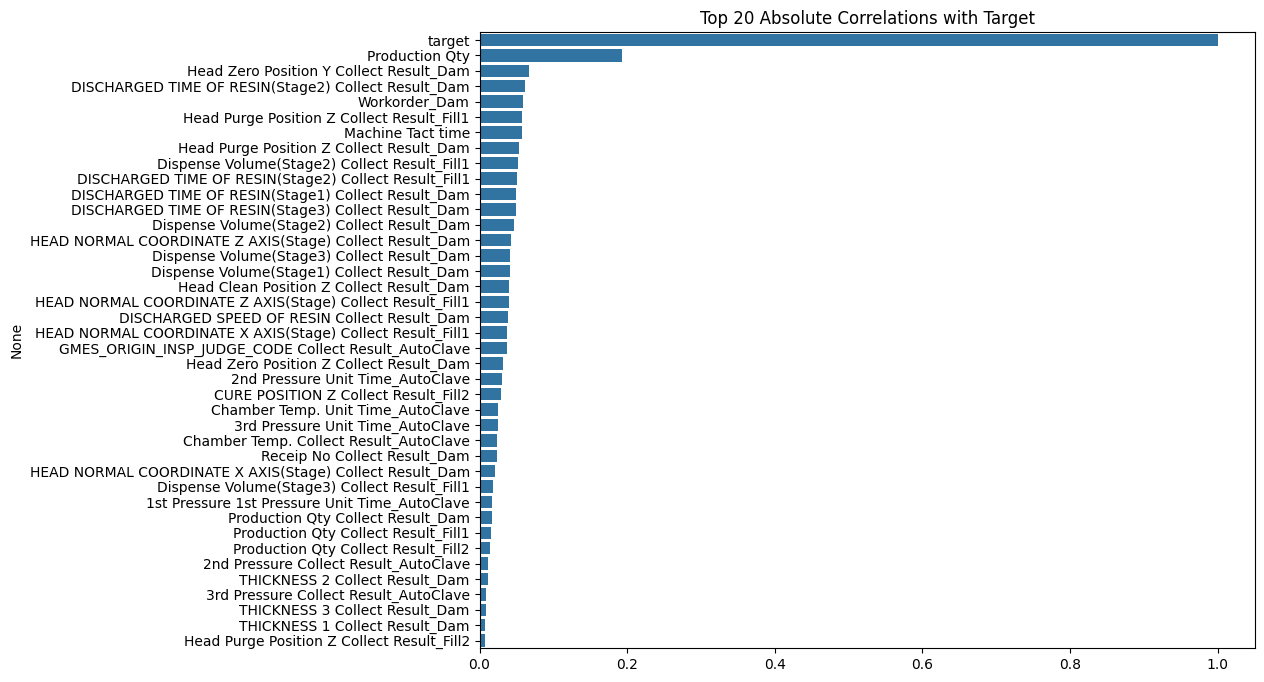

In [674]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 초기화
le = LabelEncoder()

# target과 feature 분리

# idx_line_0 = train_X['Equipment_Dam'] == 0
X = train_x.drop(columns=['target'])  # target을 제외한 피처들
y = train_X['target']  # target 변수

# target을 문자열로 변환 후 Label Encoding
y = y.astype(str)
y = le.fit_transform(y)

# 데이터프레임에 target 추가 (상관계수를 계산하기 위해)
df = X.copy()
df['target'] = y

# 상관계수 계산
correlation_matrix = df.corr()

# target과의 상관계수 추출 및 절대값 기준 상위 20개 선택
target_corr = correlation_matrix['target'].abs().sort_values(ascending=False).head(40)

top_10_corr = target_corr.head(20)
print("Top 20 Correlations with Target:")
print(top_10_corr)

# 상위 20개의 피처 목록 추출 (target 포함)
top_features = target_corr.index.tolist()
top_features.append('Equipment_Dam')
# all_data에서 상위 20개의 피처만 선택
all_data_top20 = all_data[top_features]

# 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Top 20 Absolute Correlations with Target')
plt.show()


In [675]:
all_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,...,HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Fill1,CURE POSITION X Collect Result_Dam,CURE POSITION Z Collect Result_Dam,CURE POSITION Z Collect Result_Fill2,Machine Tact time
0,0,2.862112,658,16,14.9,8.4,14.7,1.04,0.58,1.02,...,392.066667,383.700000,-1.791220,0.175862,430.033333,1.026295,790.0,31.0,-0.297461,-0.750645
1,0,2.862112,284,10,21.3,4.9,21.3,1.49,0.34,1.49,...,391.633333,377.300000,0.325817,0.086980,430.600000,0.053647,790.0,31.0,-0.297461,-0.448732
2,1,-0.413235,590,16,14.7,8.5,14.7,1.61,0.93,1.61,...,393.166667,1309.166667,-1.841803,-0.713506,1323.033333,0.175254,720.0,21.0,-0.297461,0.112322
3,1,-0.413235,252,10,21.3,8.4,21.3,1.49,0.58,1.49,...,393.300000,1271.433333,0.325817,-0.090820,1322.833333,-0.757257,720.0,21.0,-0.297461,-0.169434
4,0,-0.413235,143,10,9.7,4.9,9.6,0.67,0.34,0.67,...,390.333333,377.333333,1.046809,0.086980,430.400000,0.053647,790.0,31.0,1.723056,1.529278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,1,-0.413235,278,10,21.3,10.6,21.3,1.49,0.74,1.49,...,393.300000,1271.433333,0.325817,-0.090820,1323.033333,-0.757257,720.0,21.0,-0.297461,0.477651
17357,1,-0.413235,440,16,13.2,7.6,13.2,0.92,0.53,0.92,...,393.466667,1309.166667,-0.018266,-0.980554,1323.033333,0.904740,720.0,21.0,-0.297461,-0.728870
17358,0,-0.413235,315,16,13.2,6.6,13.2,1.45,0.72,1.45,...,392.933333,377.433333,0.383471,-0.001914,430.800000,0.053647,790.0,31.0,-0.297461,-1.045880
17359,0,-0.413235,8,10,9.7,3.9,9.7,0.67,0.27,0.67,...,390.833333,377.333333,1.046809,0.753296,430.400000,-0.757257,790.0,31.0,6.692382,1.652452


In [676]:
all_data.to_csv('all_data.csv',index=False)

In [677]:
train_X = all_data_top20[~pd.isnull(all_data['target'])]
# train_x = train_X.drop(columns='Set ID')

# PCA 적용

In [678]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 타겟 변수를 제외한 피처들만 사용
features = train_X.drop(columns=['target'])

# 데이터 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# PCA 적용
pca = PCA(n_components=0.95)  # 설명 분산의 95%를 유지하도록 설정
pca_features = pca.fit_transform(scaled_features)

# PCA 적용 후 데이터셋의 형태 확인
pca_features_shape = pca_features.shape

# 설명된 분산 비율
explained_variance = pca.explained_variance_ratio_

pca_features_shape, explained_variance

((40506, 19),
 array([0.27437625, 0.14046895, 0.08838639, 0.06492462, 0.04971623,
        0.0442113 , 0.03609068, 0.03022599, 0.02991614, 0.02634697,
        0.02454399, 0.02378525, 0.02307911, 0.02192531, 0.02048756,
        0.01925356, 0.0159798 , 0.01415671, 0.00932414]))

In [679]:
test1 = all_data_top20[pd.isnull(all_data_top20['target'])]
test2 = all_data[pd.isnull(all_data['target'])]
# test_x = test.drop(columns=['Set ID','target'])
test_x = test1.drop(columns=['target'])

In [680]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# 타겟 변수
target = train_X['target']

target = target.astype(str)
target = le.fit_transform(target)

# 데이터 분리 (학습용 80%, 검증용 20%)
X_train, X_val, y_train, y_val = train_test_split(pca_features, target, test_size=0.2, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 1. 기본 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_smote, y_train_smote)

# 예측
y_pred = model.predict(X_val)

# 성능 평가
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, digits=4)


print("기본 모델 성능")
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

기본 모델 성능
Accuracy: 0.8973093063441125
Classification Report:
               precision    recall  f1-score   support

           0     0.1684    0.2074    0.1859       458
           1     0.9518    0.9386    0.9452      7644

    accuracy                         0.8973      8102
   macro avg     0.5601    0.5730    0.5656      8102
weighted avg     0.9076    0.8973    0.9023      8102



# AbNormal에 가중치 적용

In [681]:


# 1. SMOTE를 적용하여 학습한 랜덤 포레스트 모델
model_weighted_smote = RandomForestClassifier(n_estimators=200, random_state=42, class_weight={0: 1, 1: 10})
model_weighted_smote.fit(X_train_smote, y_train_smote)

# 2. 검증 데이터셋에서 예측 수행
y_pred_weighted_val = model_weighted_smote.predict(X_val)

# 3. 성능 평가
accuracy_weighted_val = accuracy_score(y_val, y_pred_weighted_val)
classification_rep_weighted_val = classification_report(y_val, y_pred_weighted_val, digits=4)

print("SMOTE 적용 모델 성능")
print("Accuracy:", accuracy_weighted_val)
print("Classification Report:\n", classification_rep_weighted_val)

# 4. 테스트 데이터에 PCA 및 스케일러 적용
scaled_features_test = scaler.transform(test_x)
pca_features_test = pca.transform(scaled_features_test)

# 5. 테스트 데이터에서 예측 수행
y_pred_test = model_weighted_smote.predict(pca_features_test)

# 6. 결과를 DataFrame으로 저장
result = pd.DataFrame({
    'Set ID': test['Set ID'].values,  # Set ID를 원래대로 유지
    'target': y_pred_test
})

# 결과 출력
print(result.head())


SMOTE 적용 모델 성능
Accuracy: 0.8849666748950876
Classification Report:
               precision    recall  f1-score   support

           0     0.1671    0.2598    0.2034       458
           1     0.9541    0.9224    0.9380      7644

    accuracy                         0.8850      8102
   macro avg     0.5606    0.5911    0.5707      8102
weighted avg     0.9096    0.8850    0.8965      8102

                             Set ID  target
0  0001be084fbc4aaa9d921f39e595961b       1
1  0005bbd180064abd99e63f9ed3e1ac80       1
2  000948934c4140d883d670adcb609584       1
3  000a6bfd02874c6296dc7b2e9c5678a7       1
4  0018e78ce91343678716e2ea27a51c95       1


In [682]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer, f1_score

# # 랜덤 포레스트 하이퍼파라미터 그리드 설정
# param_dist = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [None, 10, 20, 30, 40],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 15}]
# }

# f1_scorer = make_scorer(f1_score, pos_label=1)

# # RandomizedSearchCV 설정
# random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(random_state=42),
#     param_distributions=param_dist,
#     n_iter=50,  # 시도할 하이퍼파라미터 조합의 수
#     scoring=f1_scorer,  # F1-score를 기준으로 최적 모델 선정
#     cv=5,  # 5-fold 교차 검증
#     # verbose=2,
#     random_state=42,
#     n_jobs=-1  # 모든 CPU 코어 사용
# )

# # SMOTE를 적용한 학습 데이터로 RandomizedSearchCV 실행
# random_search.fit(X_train_smote, y_train_smote)

# # 최적의 하이퍼파라미터로 모델 학습
# best_model = random_search.best_estimator_

# # 검증 데이터에서 예측 수행
# y_pred_weighted_val = best_model.predict(X_val)

# # 성능 평가
# accuracy_weighted_val = accuracy_score(y_val, y_pred_weighted_val)
# classification_rep_weighted_val = classification_report(y_val, y_pred_weighted_val, digits=4)

# print("최적 하이퍼파라미터를 적용한 SMOTE 모델 성능")
# print("Accuracy:", accuracy_weighted_val)
# print("Classification Report:\n", classification_rep_weighted_val)

# # 테스트 데이터에 PCA 및 스케일러 적용
# scaled_features_test = scaler.transform(test_x)
# pca_features_test = pca.transform(scaled_features_test)

# # 테스트 데이터에서 예측 수행
# y_pred_test = best_model.predict(pca_features_test)

# # 결과를 DataFrame으로 저장
# result = pd.DataFrame({
#     'Set ID': test['Set ID'].values,  # Set ID를 원래대로 유지
#     'target': y_pred_test
# })



In [683]:
# 기존 0과 1 값을 'AbNormal'과 'Normal'로 변환
submission['target'] = result['target'].map({0: 'AbNormal', 1: 'Normal'})


# 결과를 CSV 파일로 저장
submission.to_csv('submission.csv', index=False)

# 결과 확인
submission.head()


,Set ID,target
0,0001be084fbc4aaa9d921f39e595961b,Normal
1,0005bbd180064abd99e63f9ed3e1ac80,Normal
2,000948934c4140d883d670adcb609584,Normal
3,000a6bfd02874c6296dc7b2e9c5678a7,Normal
4,0018e78ce91343678716e2ea27a51c95,Normal


In [684]:
unique, counts = np.unique(submission['target'], return_counts=True)
print(unique, counts)

['AbNormal' 'Normal'] [ 1679 15682]
